In [37]:
## Imports
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from cGANtools.GAN import CGAN
#from keras.models import load_model

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
import helper as hp


### Slice of life functions

In [38]:
def load_and_generate(gen, d_scaling, ss_idx, n_samples, noise = []):
    
    sampled_labels = np.ones(n_samples).reshape(-1, 1) * cond_class  # sample conditional labels
    if len(noise)==0:
        noise = np.random.normal(0, 1, (n_samples, 127))             # generate random noise
        
    gen_par = gen.predict([noise, sampled_labels])                   # generate parameters
    
    # rescale parameters
    x_new, new_min, new_max = hp.unscale_range(gen_par, -1.0, 1.0, d_scaling['min_x'], d_scaling['max_x'])
    
    return x_new, noise

def min_2(numbers):
    # Find the index of the minimum value
    min1_index = numbers.index(min(numbers))
    
    # Temporarily replace the smallest number with a large value to find the next smallest
    temp_numbers = numbers.copy()  # Make a copy of the list
    temp_numbers[min1_index] = float('inf')  # Replace the smallest number with infinity
    
    # Find the index of the second minimum value
    min2_index = temp_numbers.index(min(temp_numbers))

    return min1_index, min2_index


### Load and generate

In [8]:
n_samples = 100
cond_class = 1
# steady state index
ss = [0]
for ss_idx in ss:
    
    # path to generators
    path_to_generator = f'best_generators/best_generator_{ss_idx}.h5'
    # Load scaling parameters
    path_to_data_scaling = f'best_generators/d_scaling_{ss_idx}'
    d_scaling = hp.load_pkl(path_to_data_scaling)
    
    sampled_labels = np.ones(n_samples).reshape(-1, 1) * cond_class  # sample conditional labels
    noise = np.random.normal(0, 1, (n_samples, 127))                 # generate random noise    
    gen = load_model(path_to_generator)                              # load saved generator
    gen_par = gen.predict([noise, sampled_labels])                   # generate parameters
    
    # rescale parameters
    x_new, new_min, new_max = hp.unscale_range(gen_par, -1.0, 1.0, d_scaling['min_x'], d_scaling['max_x'])
    # save parameters
    
    os.makedirs(f'analysis/{ss_idx}', exist_ok = True)
    #np.save(f'analysis/{ss_idx}/sample.npy', x_new)
    #np.save(f'analysis/{ss_idx}/sample_noise.npy', noise)

NameError: name 'load_model' is not defined

### Check for good points

In [39]:
latent_dim = 127
km_dim = 259
ss_idx = 5

sample_eigenvals = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values 
relevant_ix = np.where(sample_eigenvals<=-9)[0]
sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
sample = np.load(f'analysis/{ss_idx}/sample.npy')

In [40]:
#for ix, eig in enumerate(sample_eigenvals):
#    print(f'{ix}: {eig}: {-60/eig}')
ss = [2,4,5]
for ss_idx in ss:
    sample_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values 
    ix = np.where(sample_eigs<=-9)[0]
    print(len(ix))
    pd.DataFrame(ix).to_csv(f'analysis/{ss_idx}/ixs.csv')

79
87
59


### Perturb each feature of latent space for selected points

In [393]:
ss = [2,4,5]

for ss_idx in ss:
    
    # Load generator and scaling factors
    # path to generator
    path_to_generator = f'best_generators/best_generator_{ss_idx}.h5'
    gen = load_model(path_to_generator)
    # Load scaling parameters
    path_to_data_scaling = f'best_generators/d_scaling_{ss_idx}'
    d_scaling = hp.load_pkl(path_to_data_scaling)
    
    sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:,1].values
    dummy_noise = sample_noise.copy()
    perturbance = 0.5  # Increase each latent feature by 50%
    
    for ix in ixs:
        perturbed_params = []
        perturbed_noise = []
        seed_noise = dummy_noise[ix]
        
        for this_feature in range(latent_dim):
            
            # Make a copy of the original seed_noise to reset it for each feature perturbation
            temp_noise = seed_noise.copy()
    
            # Increase feature by 50%
            og_feature = temp_noise[this_feature].copy()
            new_feature = og_feature * (1 + perturbance)
            temp_noise[this_feature] = new_feature 
    
            # Now generate with modified feature
            new_param, new_noise = load_and_generate(gen, d_scaling, ss_idx, 1, np.array([list(temp_noise)]))
            
            perturbed_params.append(new_param)
            perturbed_noise.append(new_noise)
    
        # Save new noise and parameters
        savepath = f'analysis/{ss_idx}/perturbation/{ix}'
        os.makedirs(savepath, exist_ok=True)
    
        np.save(f'{savepath}/perturbed_params.npy', perturbed_params)
        np.save(f'{savepath}/perturbed_noise.npy', perturbed_noise)
    

### Plot results of single perturbation

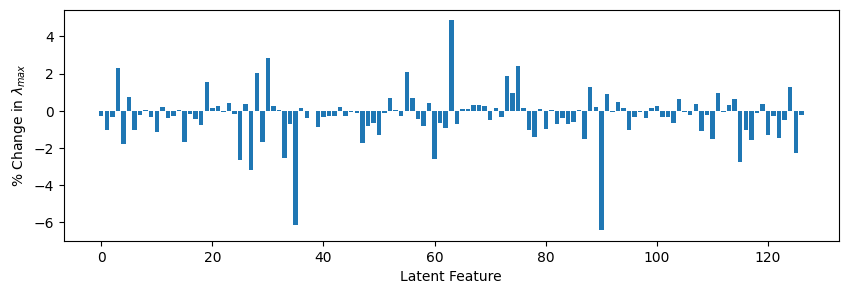

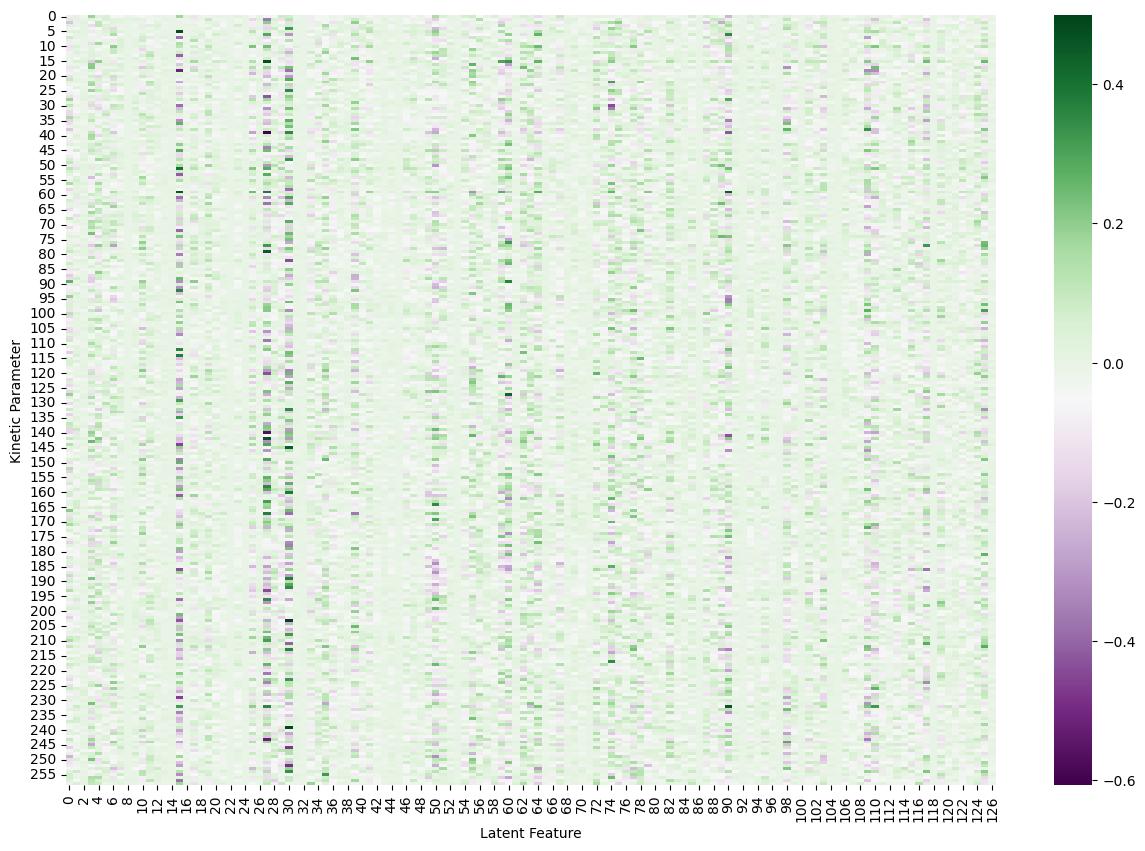

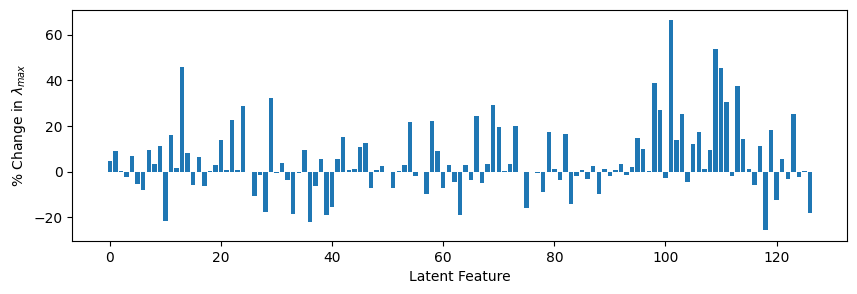

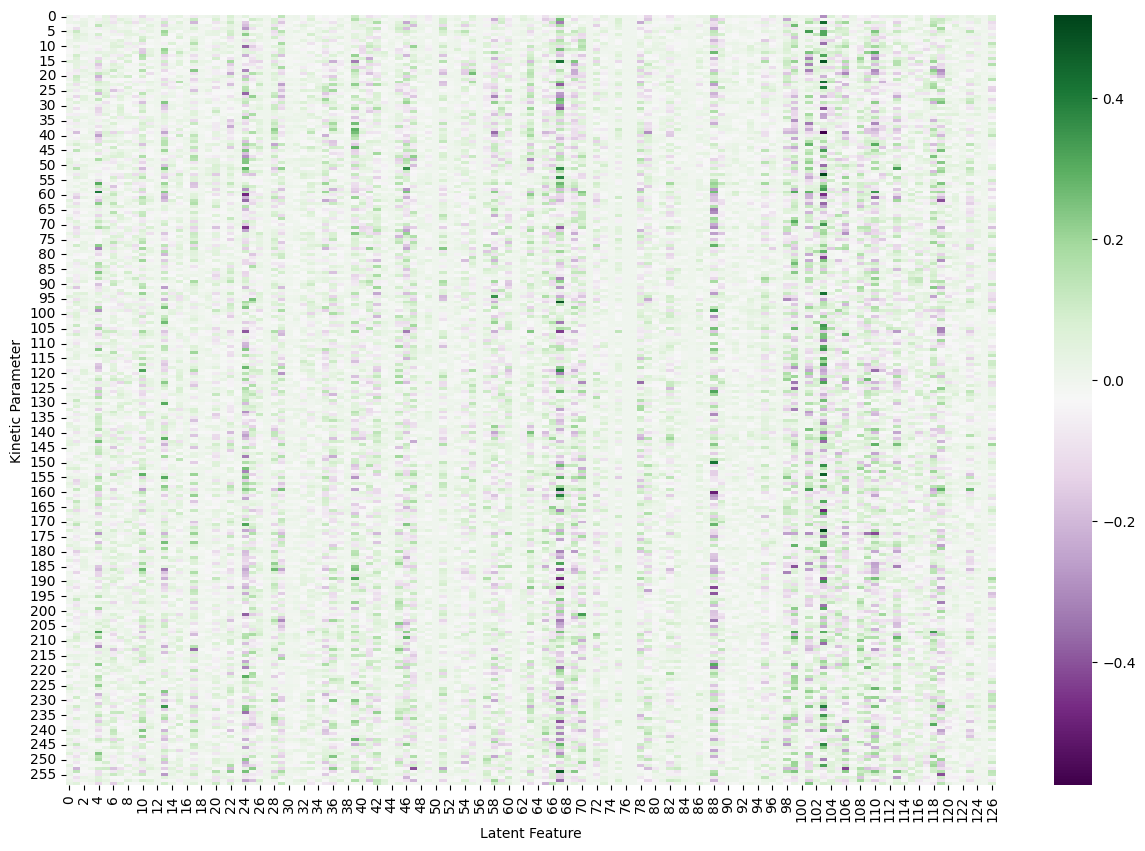

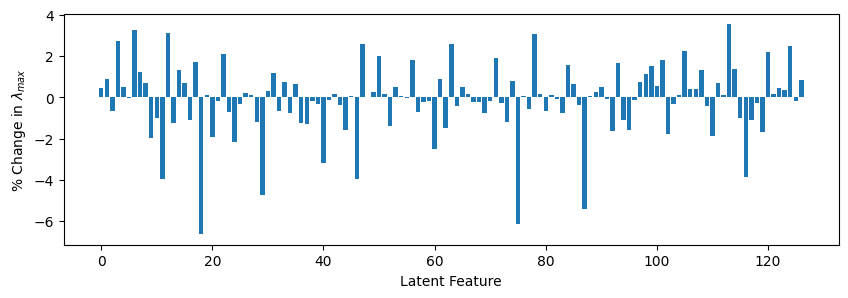

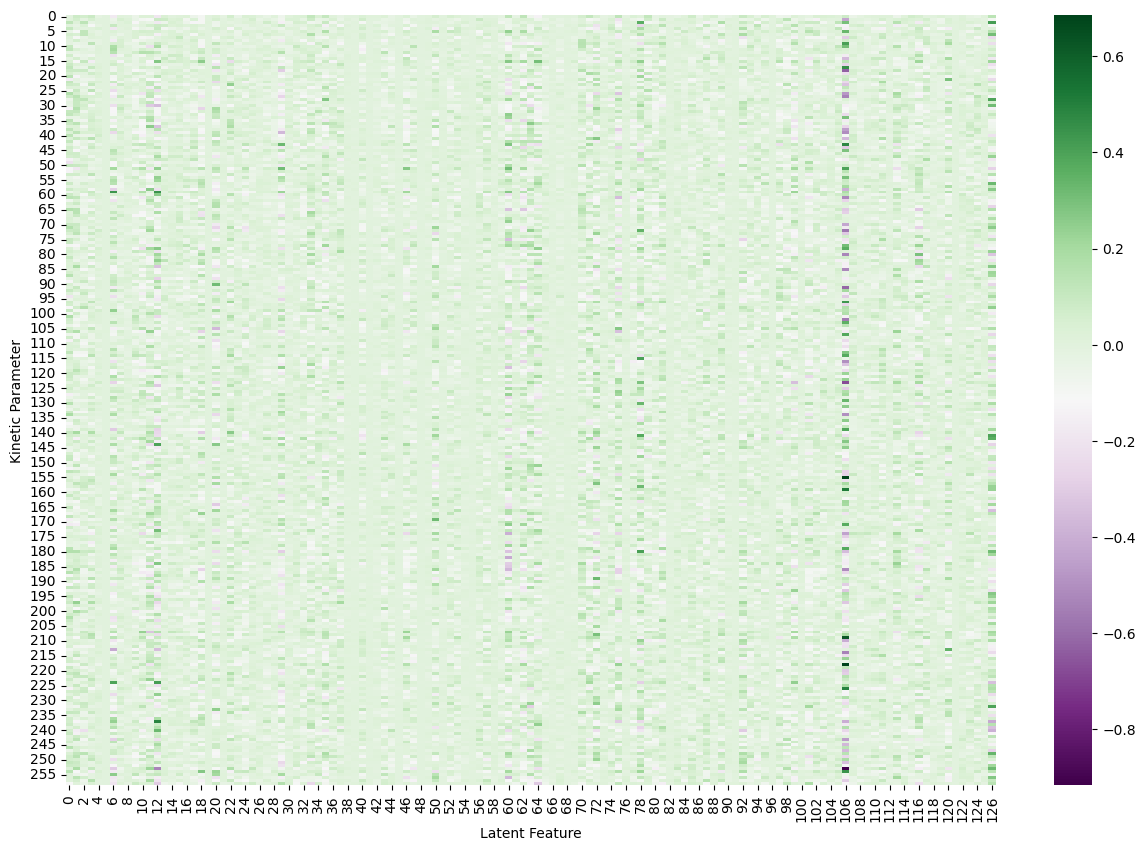

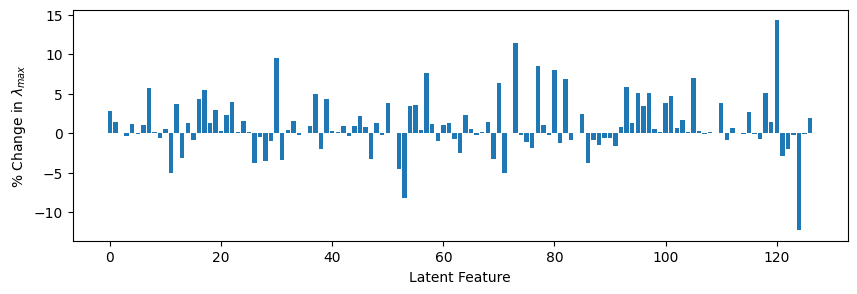

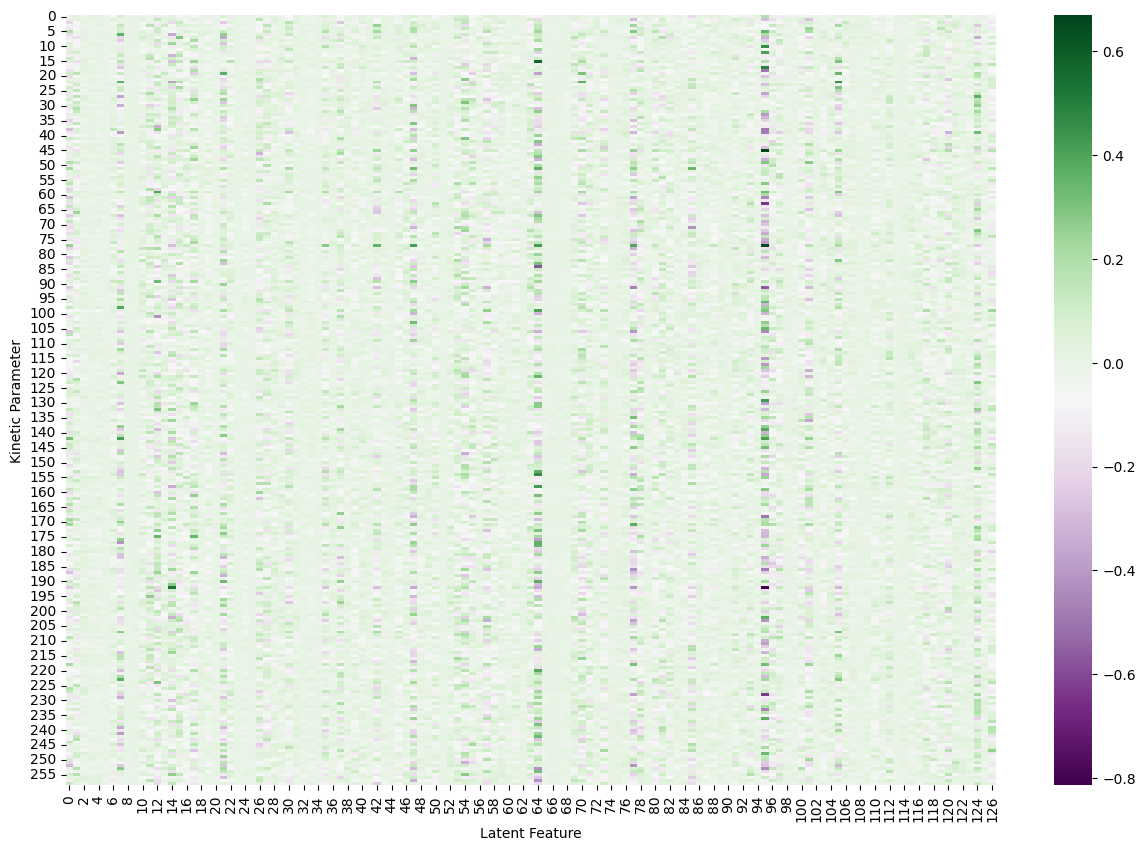

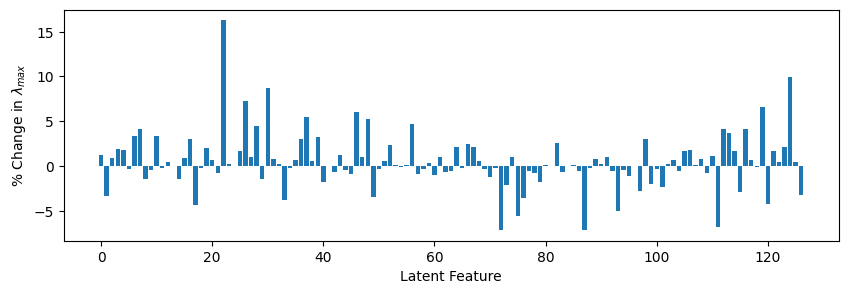

KeyboardInterrupt: 

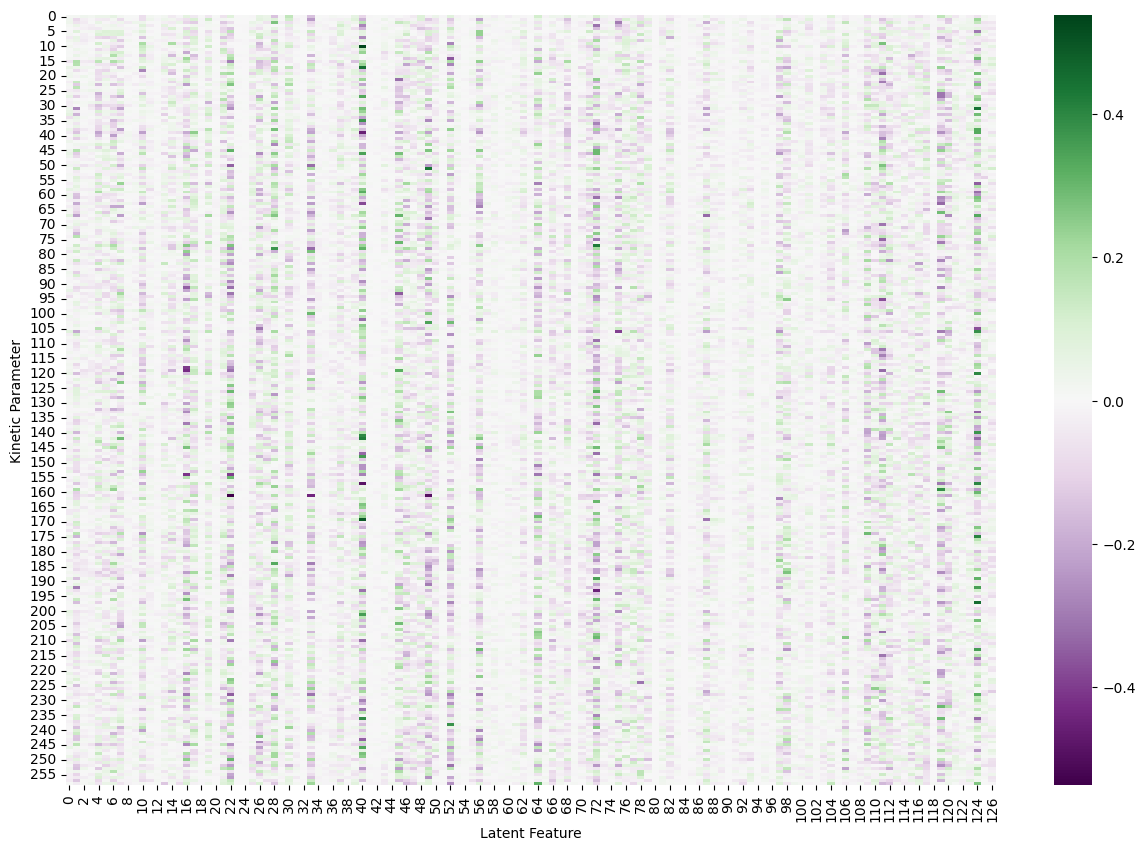

In [41]:
ss = [2,4,5]

for ss_idx in ss:
    
    sample_eigenvals = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values 
    sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
    sample = np.load(f'analysis/{ss_idx}/sample.npy')
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:,1].values
    
    for ix in ixs:
        
        perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/perturbation/{ix}/max_eig.csv').iloc[:,1].values
        seed_eig = sample_eigenvals[ix]

        pc_change = ((seed_eig-perturbed_eigs)/seed_eig)*100

        plt.figure(figsize = (10,3))
        plt.bar(np.arange(latent_dim),pc_change)
        plt.ylabel(r'% Change in $\lambda_{max}$')
        plt.xlabel('Latent Feature')

        plot_path = f'analysis/{ss_idx}/figures'
        os.makedirs(plot_path, exist_ok = True)
        plt.savefig(f'{plot_path}/{ix}_all_features.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_all_features.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

        perturbed_params = np.load(f'analysis/{ss_idx}/perturbation/{ix}/perturbed_params.npy')
        seed_params = sample[ix]
        unravel_params = np.array([this_param[0] for this_param in perturbed_params])
        pc_change_kms = []
        for this_set in range(latent_dim):
            perturbed_km = (unravel_params[this_set] - seed_params)
            pc_change_kms.append(perturbed_km)

        plt.figure(figsize = (15,10))
        sns.heatmap(np.transpose(pc_change_kms), cmap = 'PRGn')
        plt.ylabel('Kinetic Parameter')
        plt.xlabel('Latent Feature')

        plot_path = f'analysis/{ss_idx}/figures'
        os.makedirs(plot_path, exist_ok = True)
        plt.savefig(f'{plot_path}/{ix}_km_changes.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_km_changes.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

### Perturb 2 most important features at a time

In [394]:
ss = [2,4,5]

for ss_idx in ss:

    # Load generator and scaling factors
    # path to generator
    path_to_generator = f'best_generators/best_generator_{ss_idx}.h5'
    gen = load_model(path_to_generator)
    # Load scaling parameters
    path_to_data_scaling = f'best_generators/d_scaling_{ss_idx}'
    d_scaling = hp.load_pkl(path_to_data_scaling)
    
    sample_eigenvals = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values 
    sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
    sample = np.load(f'analysis/{ss_idx}/sample.npy')
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:,1].values

    dummy_noise = sample_noise.copy()
    perturbation_range = np.linspace(-2, 2, num=41)  # Create a range from -100% to 100% in 10% steps
    
    for ix in ixs:
        
        perturbed_params = []
        perturbed_noise = []
        seed_noise = dummy_noise[ix]

        #find most important features
        perturbed_eigs = list(pd.read_csv(f'analysis/{ss_idx}/perturbation/{ix}/max_eig.csv').iloc[:,1].values)
        ix1, ix2 = min_2(perturbed_eigs)
        
        for perturbance_ix1 in perturbation_range:
            for perturbance_ix2 in perturbation_range:
                # Make a copy of the original seed_noise to reset it for each perturbation pair
                temp_noise = seed_noise.copy()
    
                # Increase/decrease ix1 feature
                og_feature_ix1 = temp_noise[ix1].copy()
                new_feature_ix1 = og_feature_ix1 * (1 + perturbance_ix1)
                temp_noise[ix1] = new_feature_ix1 
                
                # Increase/decrease ix2 feature
                og_feature_ix2 = temp_noise[ix2].copy()
                new_feature_ix2 = og_feature_ix2 * (1 + perturbance_ix2)
                temp_noise[ix2] = new_feature_ix2 
    
                # Now generate with modified features
                new_param, new_noise = load_and_generate(gen, d_scaling, ss_idx, 1, np.array([list(temp_noise)]))
                
                perturbed_params.append(new_param)
                perturbed_noise.append(new_noise)
    
        # Save new noise and parameters
        savepath = f'analysis/{ss_idx}/latent_heatmap/{ix}'
        os.makedirs(savepath, exist_ok=True)
    
        np.save(f'{savepath}/perturbed_params_2.npy', perturbed_params)
        np.save(f'{savepath}/perturbed_noise_2.npy', perturbed_noise)

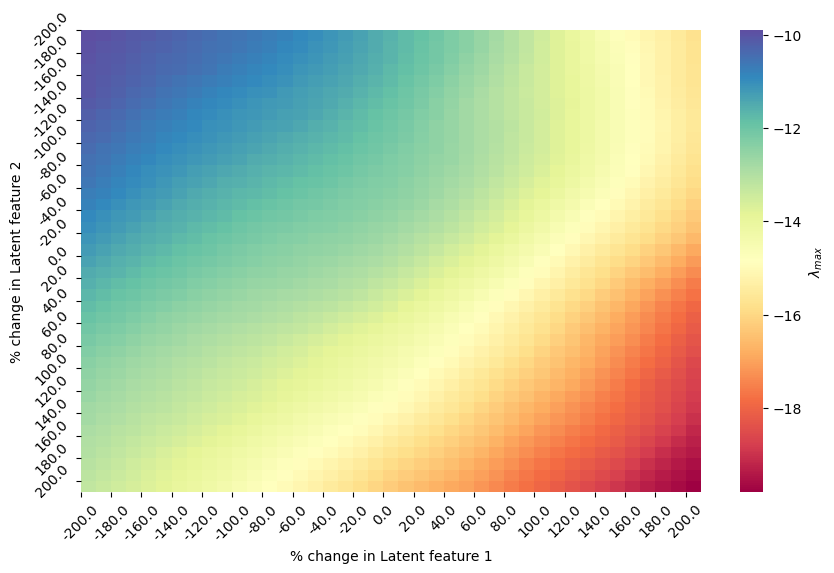

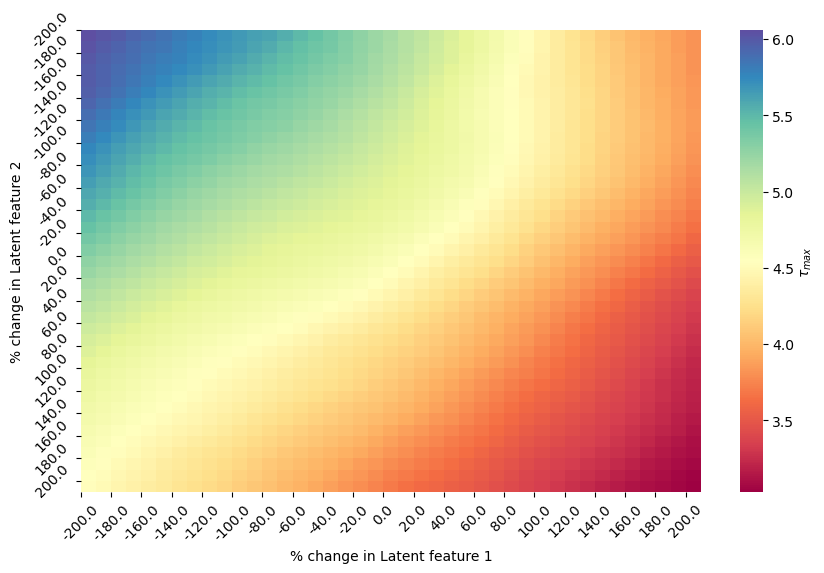

***************


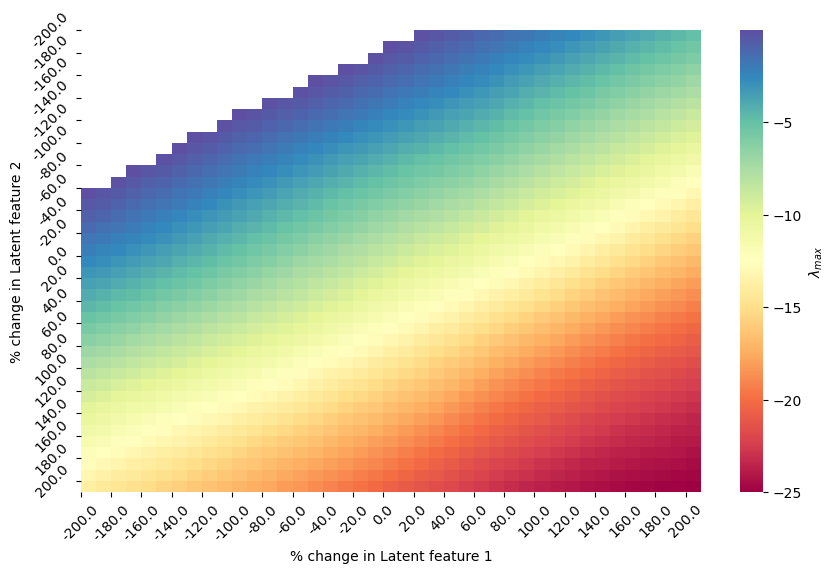

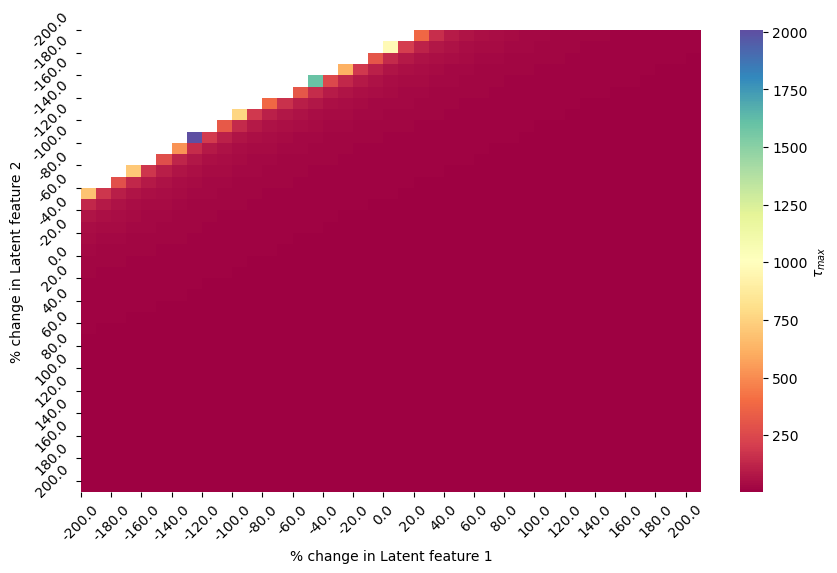

***************


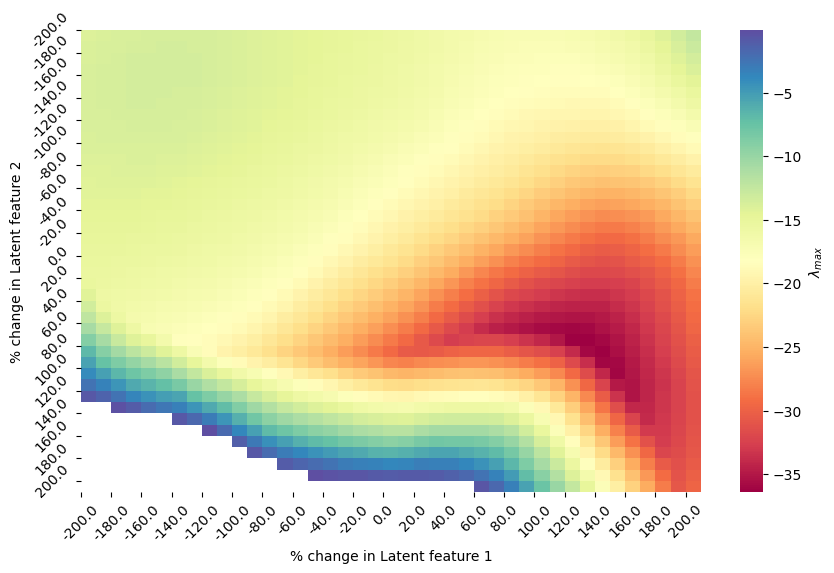

***************


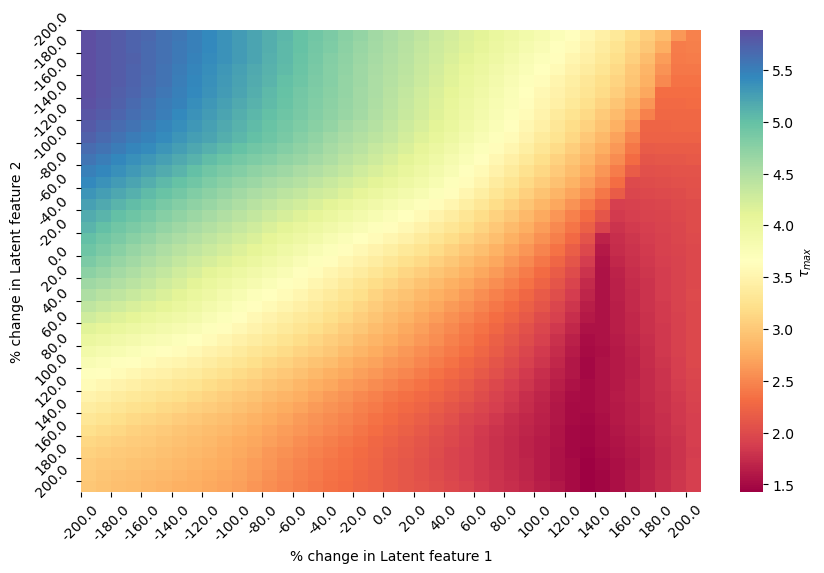

***************


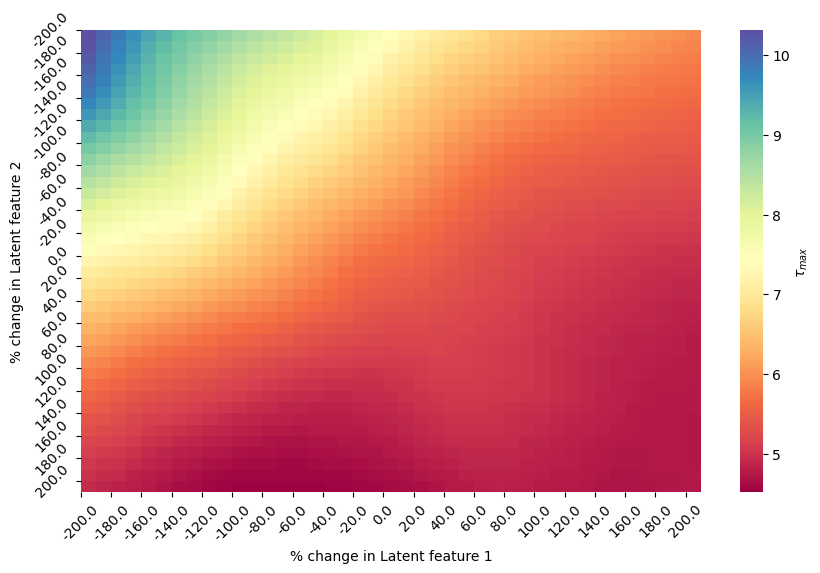

***************


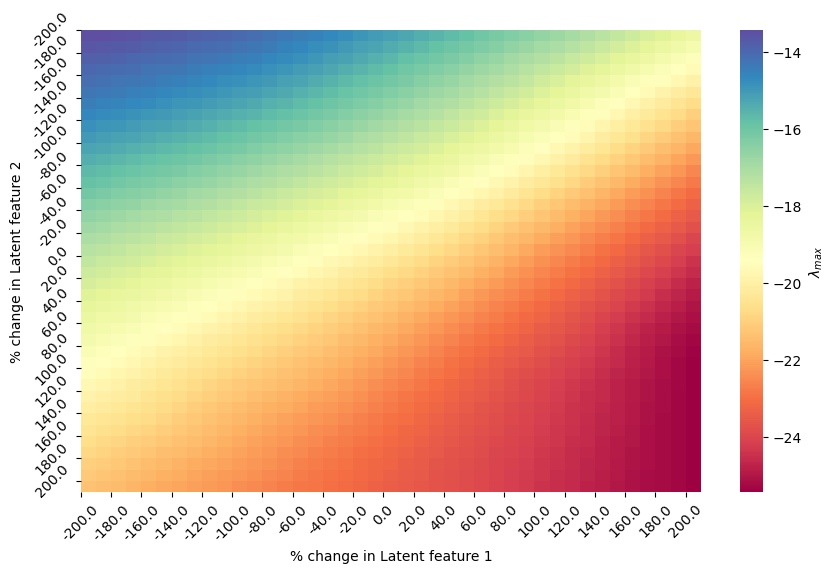

***************


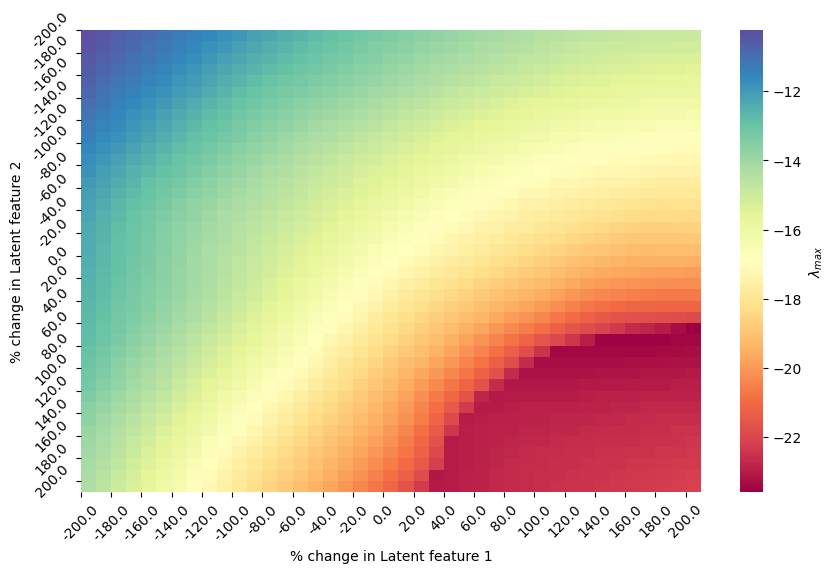

***************


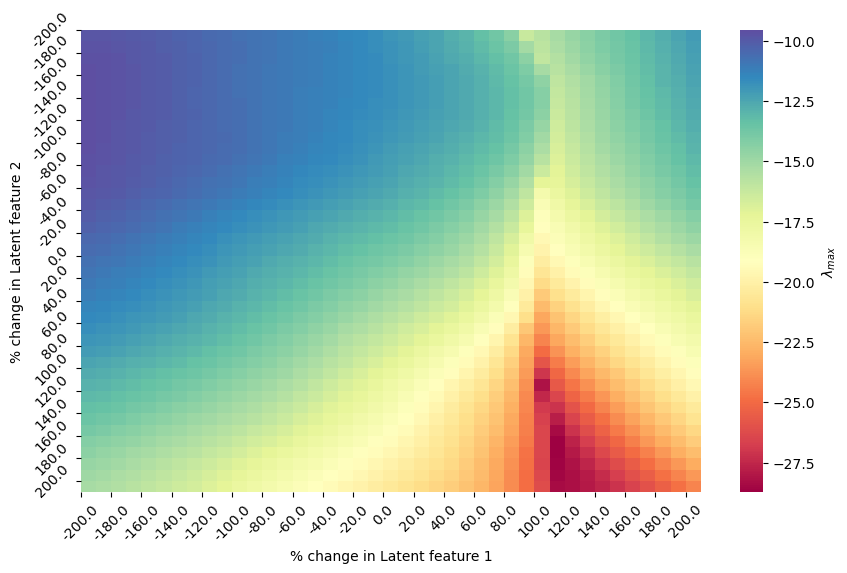

***************


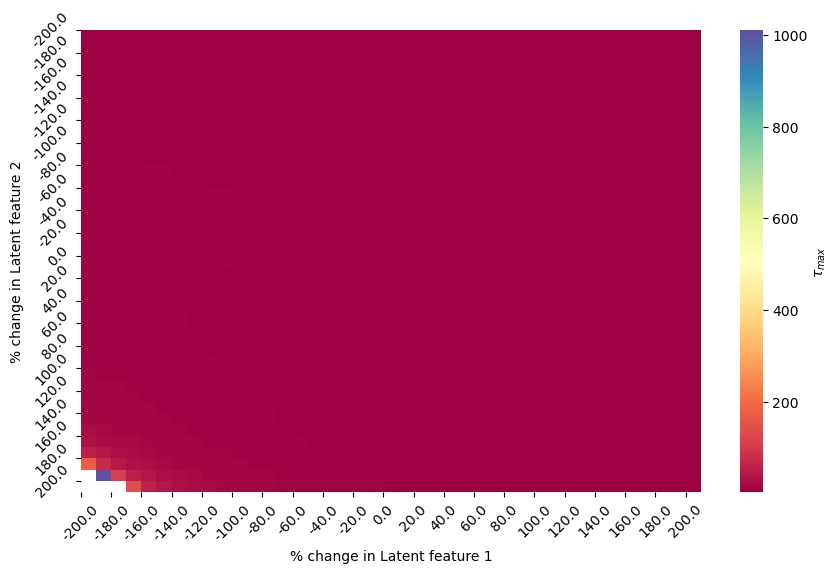

***************


***************


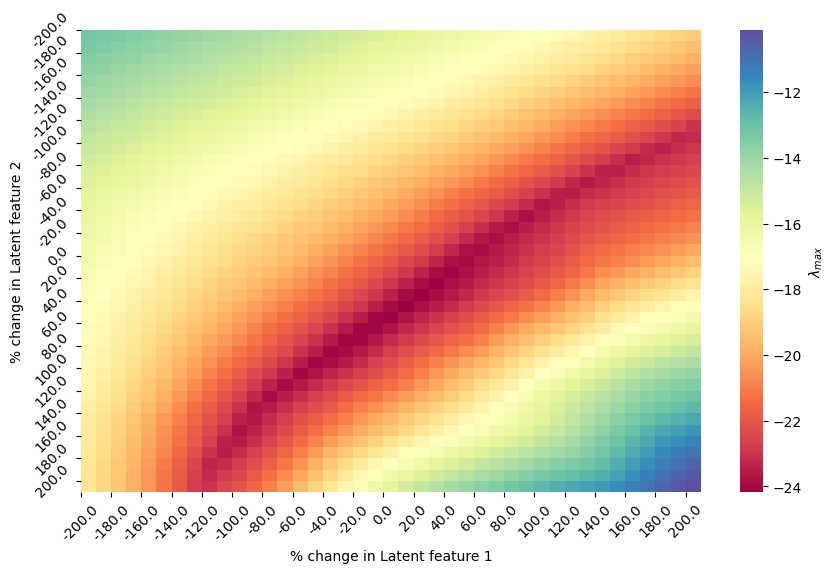

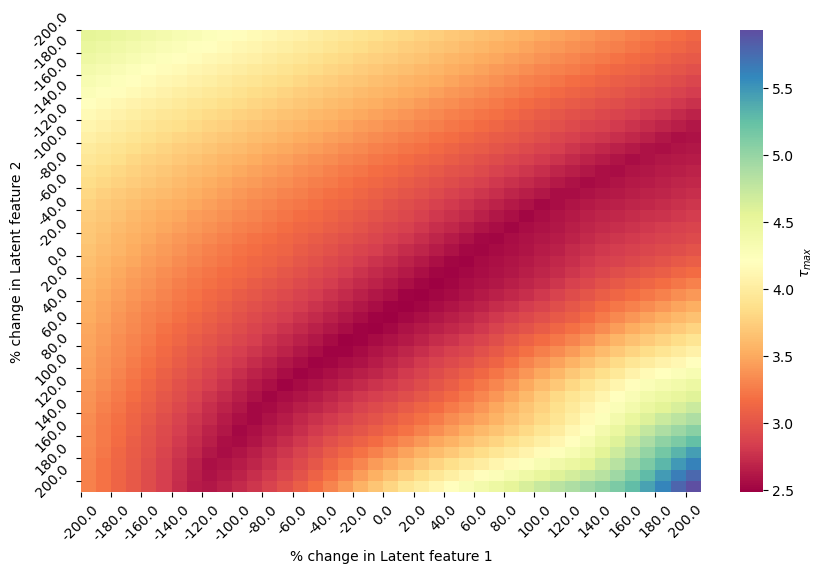

***************


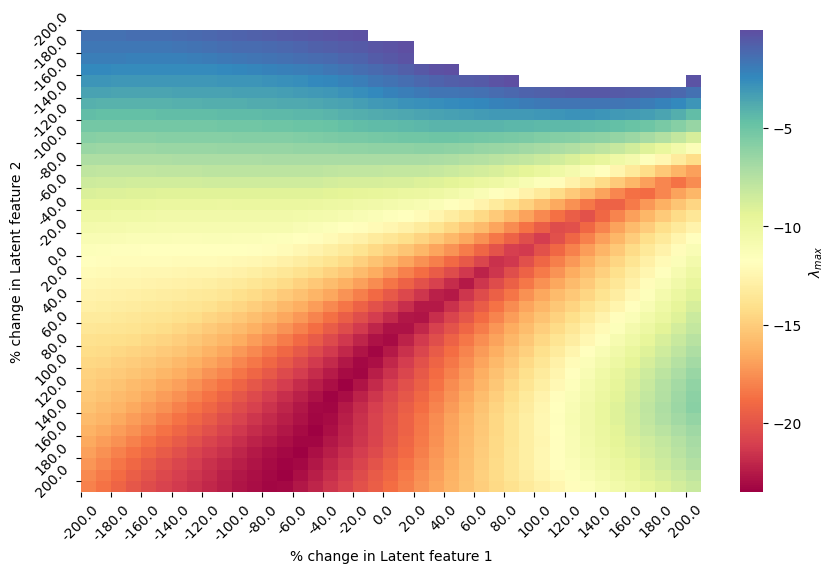

***************


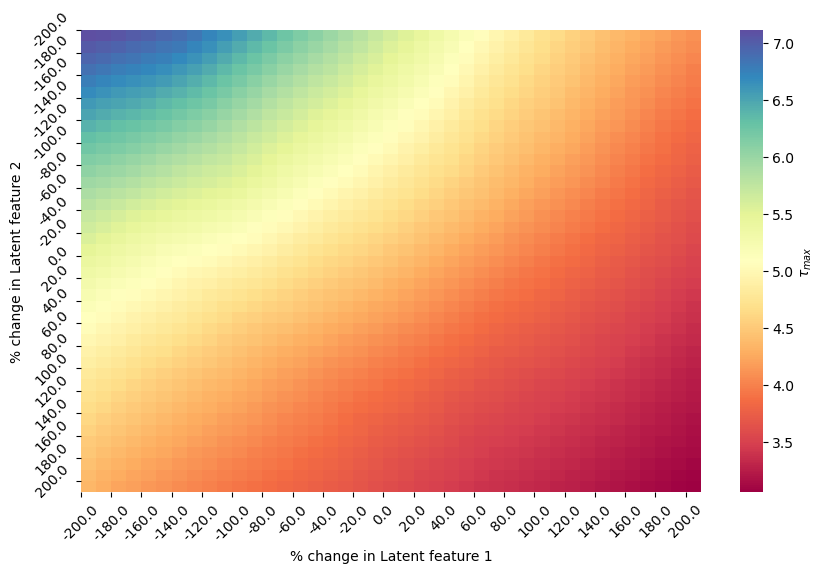

***************


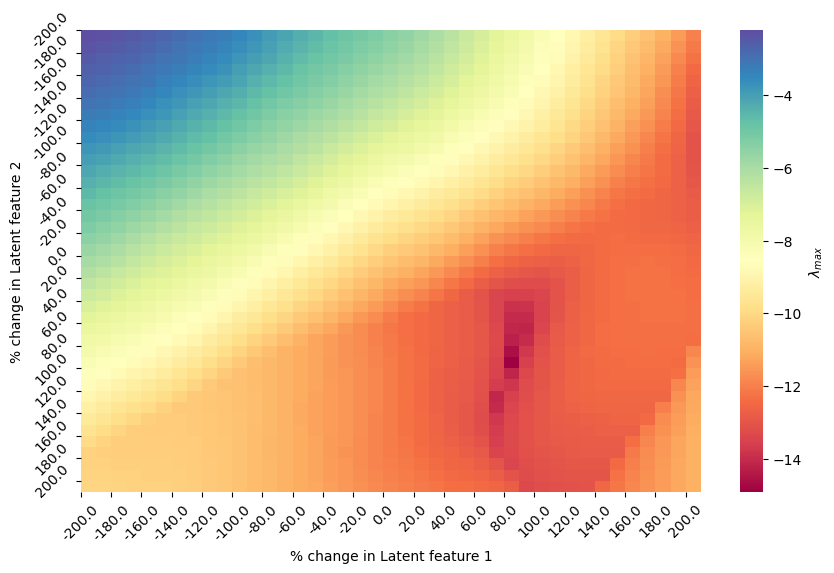

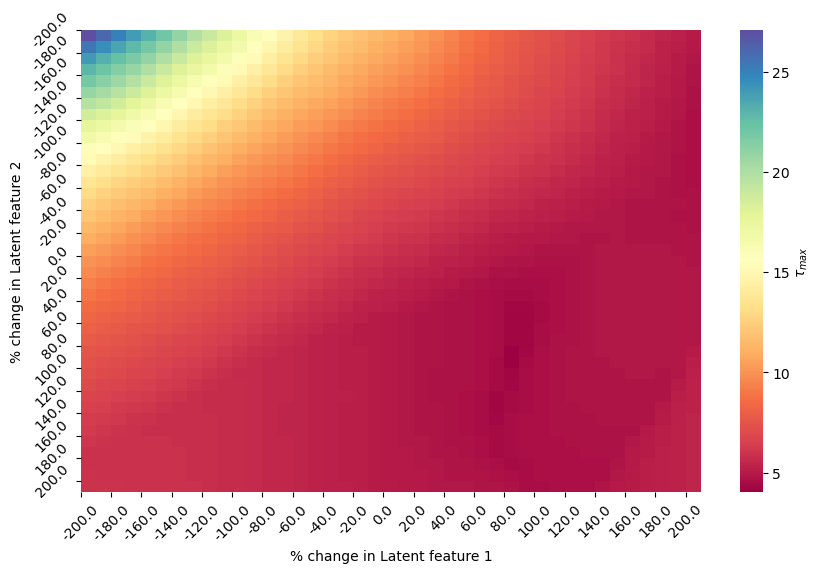

***************


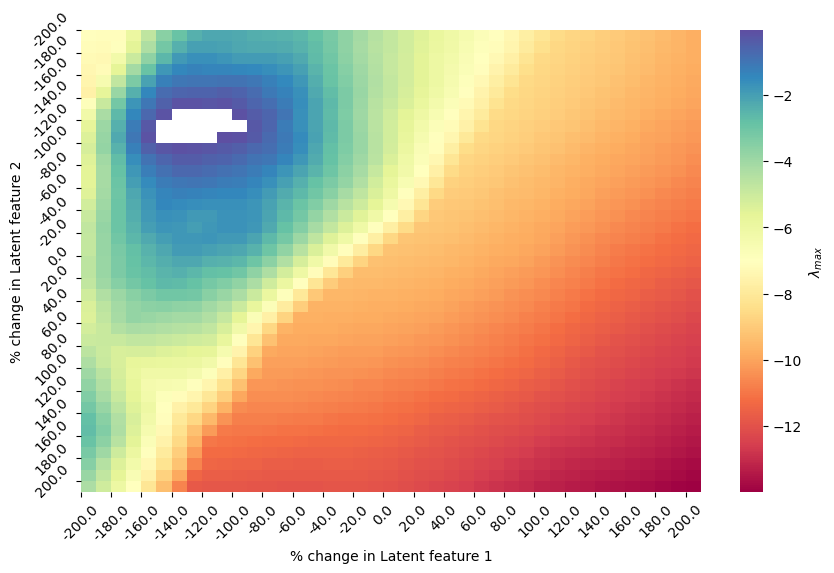

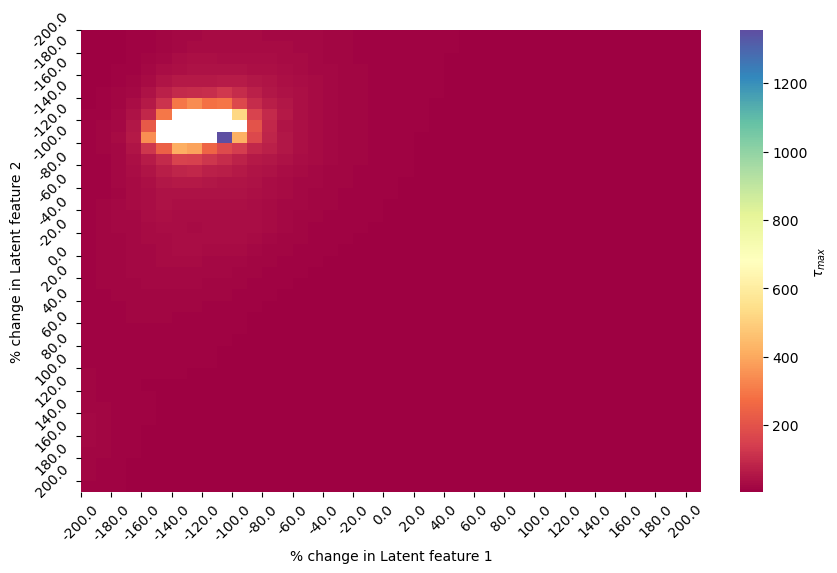

***************


In [224]:
ss = [2, 4, 5]
# Step 1: Determine the global min and max for the colorbar scale
global_min = float('inf')
global_max = float('-inf')
# First pass: Find the min and max values
for ss_idx in ss:
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    for ix in ixs:
        perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/latent_heatmap/{ix}/max_eig_2.csv').iloc[:, 1].values
        latent_mat = np.reshape(perturbed_eigs, (41, 41))
        global_min = min(global_min, latent_mat.min())
        global_max = max(global_max, latent_mat.max())

# Step 2: Generate the heatmaps with consistent colorbar scale
for ss_idx in ss:
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    plot_path = f'analysis/{ss_idx}/figures'
    for ix in ixs:
        perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/latent_heatmap/{ix}/max_eig_2.csv').iloc[:, 1].values
        
        # Plot lambda max landscape
        
        latent_mat = np.reshape(perturbed_eigs, (41, 41))
        # Set values greater than 0 to NaN
        latent_mat[latent_mat > 0] = np.nan

        plt.figure(figsize=(10, 6))
        #plt.title(f'{ss_idx}:{ix}')
        #sns.heatmap(latent_mat, cmap='Spectral', vmin=global_min, vmax=global_max)
        sns.heatmap(latent_mat, cmap='Spectral', cbar_kws={'label': r'$\lambda_{max}$'})
        plt.xticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45)
        plt.yticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45)
        plt.xlabel('% change in Latent feature 1')
        plt.ylabel('% change in Latent feature 2')
        plt.savefig(f'{plot_path}/{ix}_latent_heatmap_lambda.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_latent_heatmap_lambda.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

        # Plot tau max landscape
        
        latent_mat = np.reshape(perturbed_eigs, (41, 41))
        latent_mat = -60/latent_mat
        # Set values less than 0 to NaN
        latent_mat[latent_mat < 0] = np.nan

        plt.figure(figsize=(10, 6))
        #plt.title(f'{ss_idx}:{ix}')
        #sns.heatmap(latent_mat, cmap='Spectral', vmin=global_min, vmax=global_max)
        sns.heatmap(latent_mat, cmap='Spectral', cbar_kws={'label': r'$\tau_{max}$'})
        
        plt.xticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45)
        plt.yticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45)
        plt.xlabel('% change in Latent feature 1')
        plt.ylabel('% change in Latent feature 2')
        plt.savefig(f'{plot_path}/{ix}_latent_heatmap_tau.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_latent_heatmap_tau.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

        print('***************')

### Correlation with Kms

In [20]:
ss = [2]#, 4, 5]
names_km = pd.read_csv('../models/varma_ecoli_small/parameter_names_km_fdp1.csv').iloc[:,1].values
for ss_idx in ss:
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    og_sample = np.load(f'analysis/{ss_idx}/sample.npy')
    
    for ix in [13]:# ixs:
        gen_params = np.load(f'analysis/{ss_idx}/latent_heatmap/{ix}/perturbed_params_2.npy')
        gen_params = np.array([list(this_param[0]) for this_param in gen_params])
        max_eigs = pd.read_csv(f'analysis/{ss_idx}/latent_heatmap/{ix}/max_eig.csv').iloc[:,1].values
        all_corrs = []
        seed_param = og_sample[ix]
        for this_km in range(259):

            seed_km = seed_param[this_km]
            this_km_val = gen_params[:, this_km]
            this_corr = np.corrcoef(max_eigs, this_km_val)[0][1]
            
            all_corrs.append(this_corr)
            
            plt.figure(figsize = (10,6))
            
            this_km_val = np.reshape(this_km_val, (41, 41))
            data_min = np.min(this_km_val - seed_km)
            data_max = np.max(this_km_val - seed_km)
            abs_max = max(abs(data_min), abs(data_max))
            sns.heatmap(this_km_val - seed_km, cmap='PiYG', center=0, vmin=-abs_max, vmax=abs_max, cbar_kws={'label': r'Change in $\log{K_M}$'})
            plt.xticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45, fontsize = 10)
            plt.yticks(np.arange(41)[::2], np.linspace(-200, 200, num=41)[::2], rotation=45, fontsize = 10)
            plt.xlabel('% change in Latent feature 1')
            plt.ylabel('% change in Latent feature 2')

            this_plot_path = f'analysis/{ss_idx}/figures/km_latent/{ix}/'
            os.makedirs(this_plot_path, exist_ok = True)
            
            plt.savefig(f'{this_plot_path}/{names_km[this_km]}.svg', dpi=300, transparent=False, bbox_inches='tight')
            #plt.savefig(f'{this_plot_path}/{names_km[this_km]}.png', dpi=300, transparent=False, bbox_inches='tight')
            #plt.show()
            plt.close()
            
        
        all_corrs = pd.DataFrame([np.arange(259), names_km, all_corrs]).transpose()
        all_corrs.columns = ['index', 'name', 'correlation']
        all_corrs = all_corrs.sort_values(by = 'correlation')

        
        plt.figure(figsize = (5,5))
        plt.hist(all_corrs['correlation'], bins = 50)
        plt.xlim([-1,1])
        plt.xlabel(r'$\rho$')
        plt.ylabel('Density')
        
        plotpath = f'analysis/{ss_idx}/figures'
        plt.savefig(f'{plotpath}/{ix}_km_correlation.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plotpath}/{ix}_km_correlation.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()
        
        savepath = f'analysis/{ss_idx}/km_heatmap/{ix}/'
        os.makedirs(savepath, exist_ok = True)
        #all_corrs.to_csv(f'{savepath}correlation.csv')      

### Perturb parameters with highest correlations

In [397]:
ss = [2, 4, 5]
n_kms = 10

for ss_idx in ss:
    
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    og_sample = np.load(f'analysis/{ss_idx}/sample.npy')
    
    for ix in ixs:

        seed_set = og_sample[ix]
        path = f'analysis/{ss_idx}/km_heatmap/{ix}/correlation.csv'
        corrs = pd.read_csv(path)

        neg_corr_ix = corrs['index'].values[:n_kms]
        pos_corr_ix = corrs['index'].values[-n_kms:]

        corr_ix = np.hstack((neg_corr_ix, pos_corr_ix))
        pd.DataFrame(corr_ix).to_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/correlation_ix.csv')

        perturb_range = np.linspace(-2,2, num = 41)
        
        for this_ix in corr_ix:
            perturbed_km_set = []
            
            for perturb in perturb_range:
                
                this_km_value = seed_set[this_ix]*(1+perturb)
                dummy_set = seed_set.copy()
                dummy_set[this_ix] = this_km_value
                perturbed_km_set.append(dummy_set)

            savepath = f'analysis/{ss_idx}/km_heatmap/{ix}/perturbation/'
            os.makedirs(savepath, exist_ok = True)
            np.save(f'{savepath}{this_ix}.npy', perturbed_km_set)


### Visualize 'one-at-a-time' Km perturbations and sort out 2 with highest effect and perturb both simulataneously

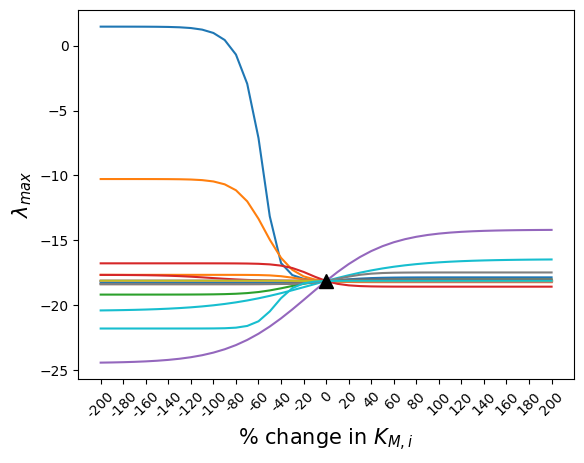

In [24]:
ss = [2,4,5]
perturb_range = np.linspace(-2,2, num = 41)

for ss_idx in [2]:
    
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values
    og_sample = np.load(f'analysis/{ss_idx}/sample.npy')
    
    for ix in [16]:
        
        sample_eig = og_max_eigs[ix]
        sample_param = og_sample[ix]
        corr_ix = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/correlation_ix.csv').iloc[:,1].values
        corr_kms = names_km[corr_ix]
        
        #plt.figure(figsize = (8,3))
        
        rmse = []
        for this_ix in corr_ix:
            
            these_eigs = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/perturbation/{this_ix}_max_eig.csv').iloc[:,1].values
            this_rmse = np.sum([(this_eig - sample_eig)**2 for this_eig in these_eigs])
            rmse.append(this_rmse)
            plt.plot(perturb_range, these_eigs)

        rmse = pd.DataFrame([corr_ix, names_km[corr_ix], rmse/max(rmse)]).transpose()
        rmse.columns = ['index', 'name', 'effect']
        rmse = rmse.sort_values(by = 'effect')
        rmse.to_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/causation_ix.csv')

        
        plt.plot(0, sample_eig, 'k^', markersize = 10)
        plt.ylabel(r'$\lambda_{max}$', fontsize = 15)
        plt.xlabel(r'% change in $K_{M,i}$', fontsize = 15)
        plt.xticks(perturb_range[::2], [f'{int(np.round(this_tick,2)*100)}' for this_tick in perturb_range[::2]], rotation = 45)
        
        plotpath = f'analysis/{ss_idx}/figures'
        #plt.savefig(f'{plotpath}/{ix}_km_perturb.svg', dpi=300, transparent=False, bbox_inches='tight')
        #plt.savefig(f'{plotpath}/{ix}_km_perturb.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        
        plt.close()

        ## Now perturb 2 most causative kms simultaneously
        # Define the perturbation range
        perturbation_range = np.linspace(-1, 1, num=21)
        
        # Extract the indices of the two most causative features
        ix1, ix2 = rmse['index'].values[-1], rmse['index'].values[-2]
        
        perturbed_params = []
        for perturbance_ix1 in perturbation_range:
            for perturbance_ix2 in perturbation_range:
            
                # Make a copy of the original sample_param to reset it for each perturbation pair
                temp_sample = sample_param.copy()
                # Perturb ix1 feature
                temp_sample[ix1] *= (1 + perturbance_ix1)
                # Perturb ix2 feature
                temp_sample[ix2] *= (1 + perturbance_ix2)
                perturbed_params.append(temp_sample)
            
        # Save the perturbed parameters
        savepath = f'analysis/{ss_idx}/km_heatmap/{ix}'
        os.makedirs(savepath, exist_ok=True)
        
        # Convert the list of perturbed parameters to a numpy array
        perturbed_params = np.array(perturbed_params)
        
        # Save the numpy array to a file
        #np.save(f'{savepath}/perturbed_params.npy', perturbed_params)
        

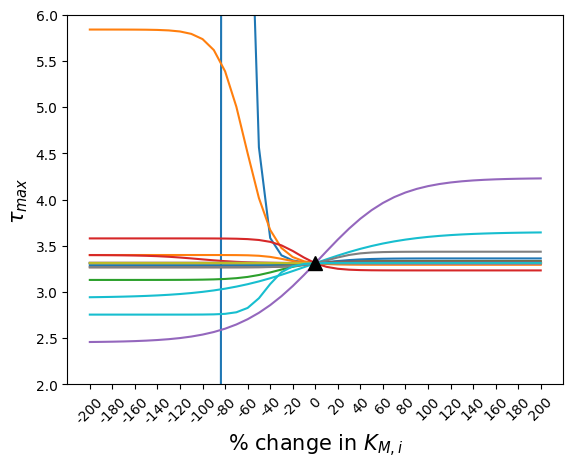

In [33]:
ss = [2,4,5]
perturb_range = np.linspace(-2,2, num = 41)

for ss_idx in [2]:
    
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    og_max_eigs = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values
    og_sample = np.load(f'analysis/{ss_idx}/sample.npy')
    
    for ix in [16]:
        
        sample_eig = og_max_eigs[ix]
        sample_param = og_sample[ix]
        corr_ix = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/correlation_ix.csv').iloc[:,1].values
        corr_kms = names_km[corr_ix]
        
        #plt.figure(figsize = (8,3))
        
        rmse = []
        for this_ix in corr_ix:
            
            these_eigs = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/perturbation/{this_ix}_max_eig.csv').iloc[:,1].values
            this_rmse = np.sum([(this_eig - sample_eig)**2 for this_eig in these_eigs])
            rmse.append(this_rmse)
            plt.plot(perturb_range, -60/these_eigs)

        rmse = pd.DataFrame([corr_ix, names_km[corr_ix], rmse/max(rmse)]).transpose()
        rmse.columns = ['index', 'name', 'effect']
        rmse = rmse.sort_values(by = 'effect')
        rmse.to_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/causation_ix.csv')

        
        plt.plot(0, -60/sample_eig, 'k^', markersize = 10)
        plt.ylabel(r'$\tau_{max}$', fontsize = 15)
        plt.xlabel(r'% change in $K_{M,i}$', fontsize = 15)
        plt.ylim([2,6])
        plt.xticks(perturb_range[::2], [f'{int(np.round(this_tick,2)*100)}' for this_tick in perturb_range[::2]], rotation = 45)
        
        plotpath = f'figures/figure_3/'
        plt.savefig(f'{plotpath}/{ix}_km_perturb.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plotpath}/{ix}_km_perturb.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        
        plt.close()


In [36]:
-60/9

-6.666666666666667

### Visualize $K_M$ heatmap

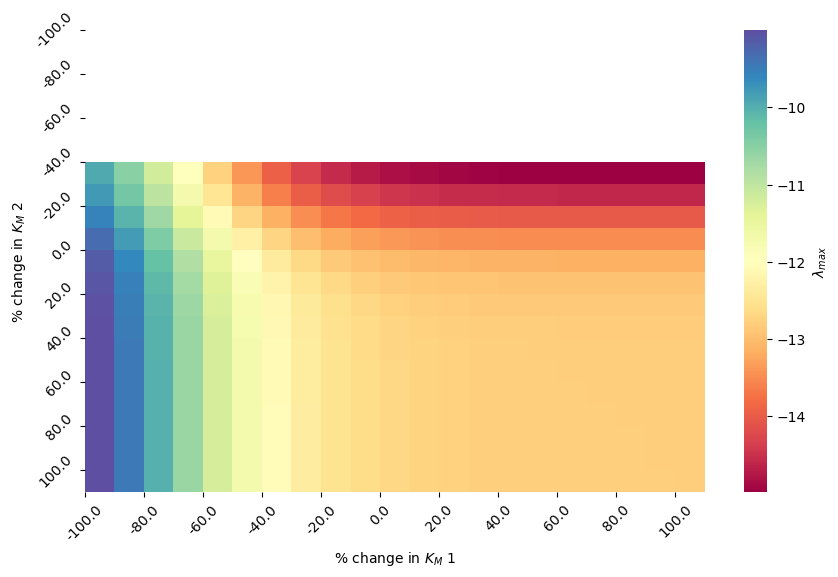

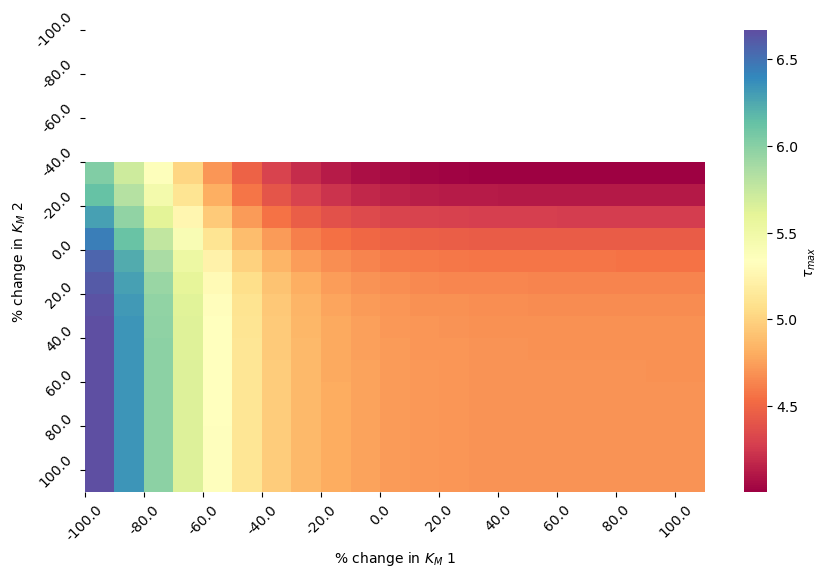

***************


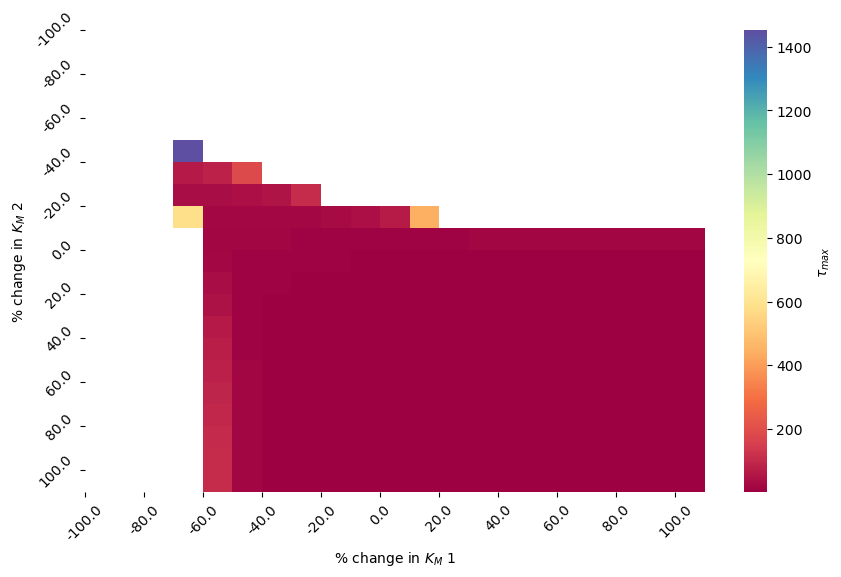

***************


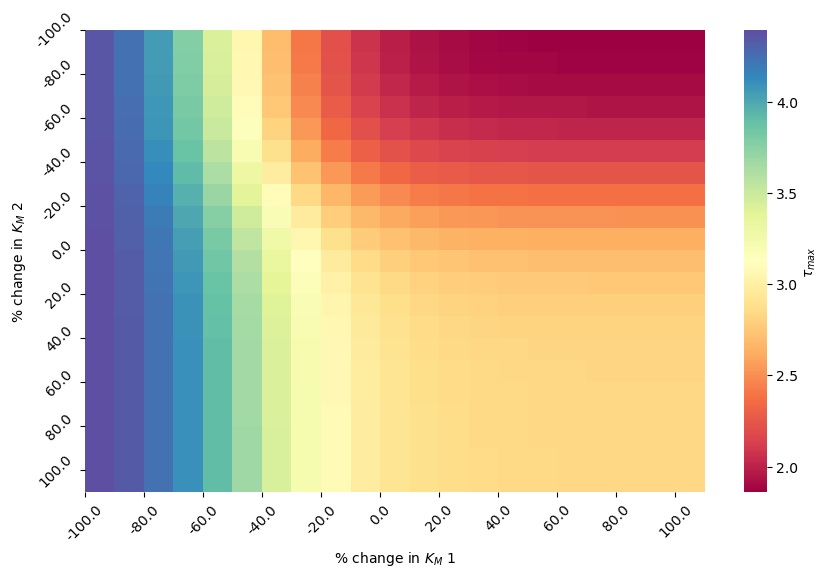

***************


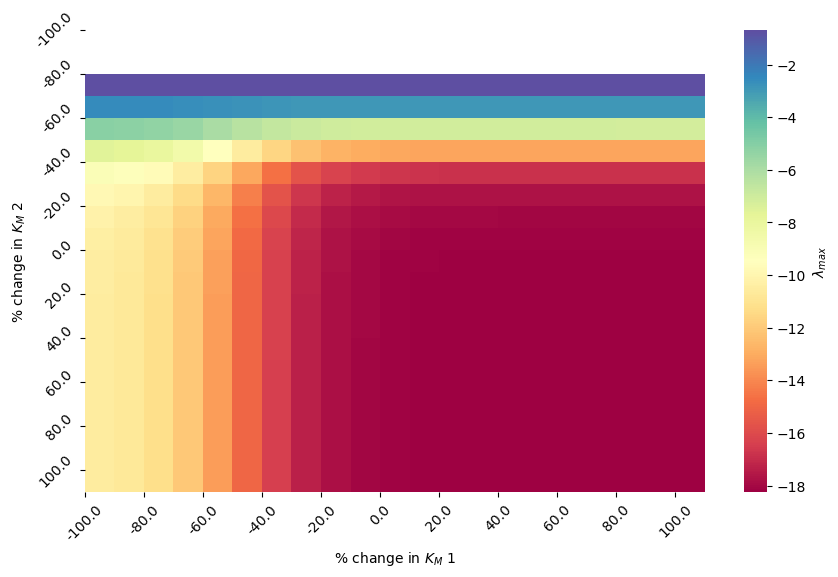

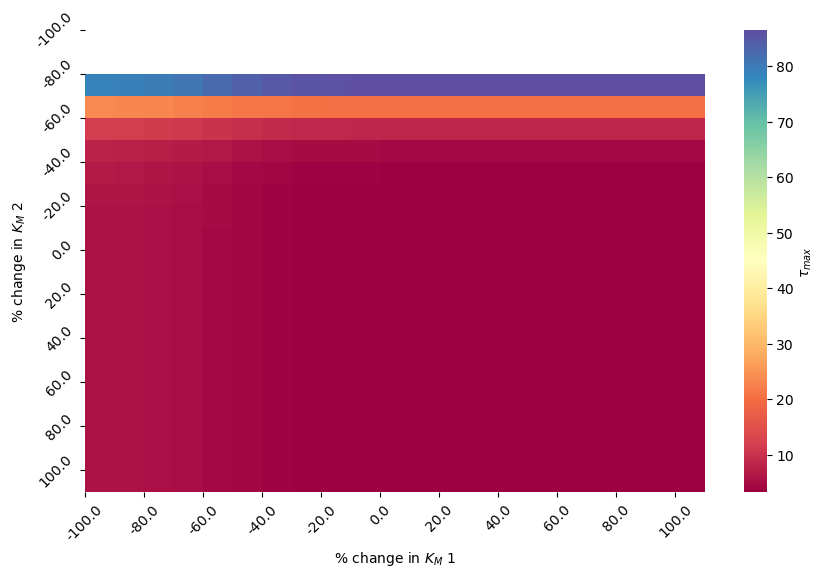

***************


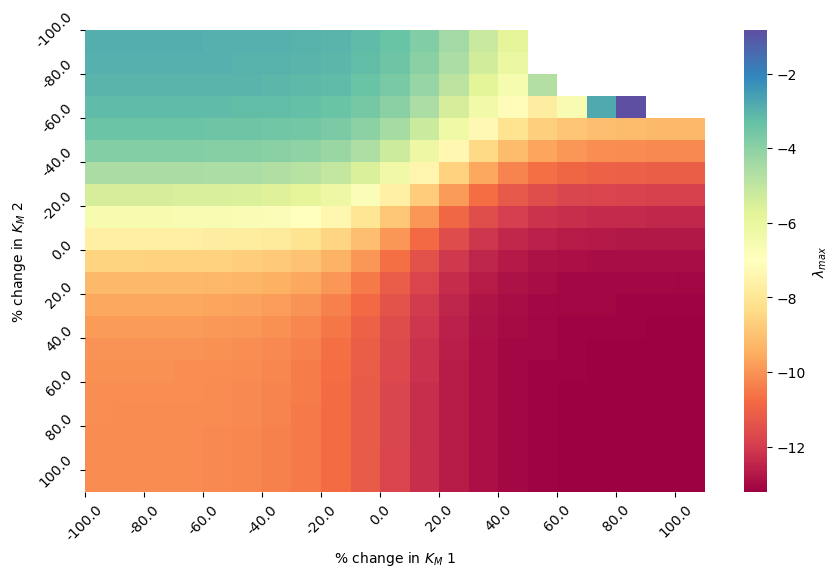

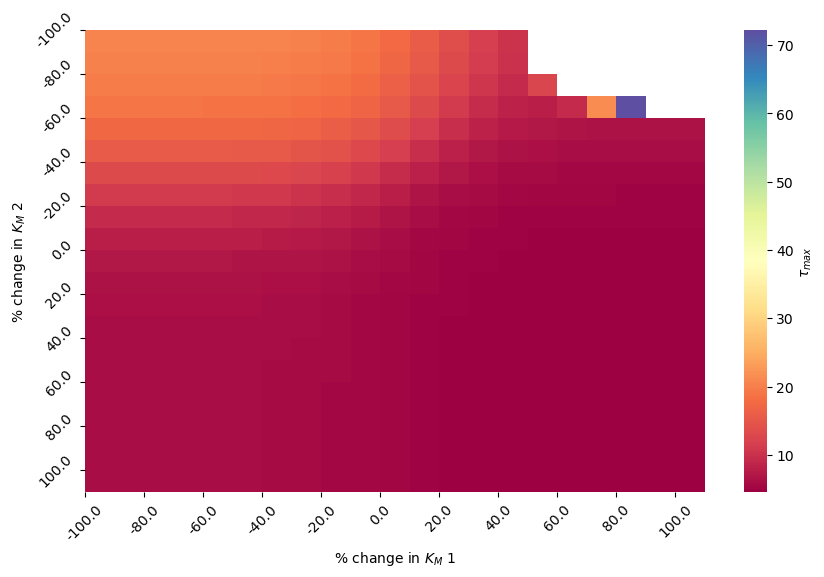

***************


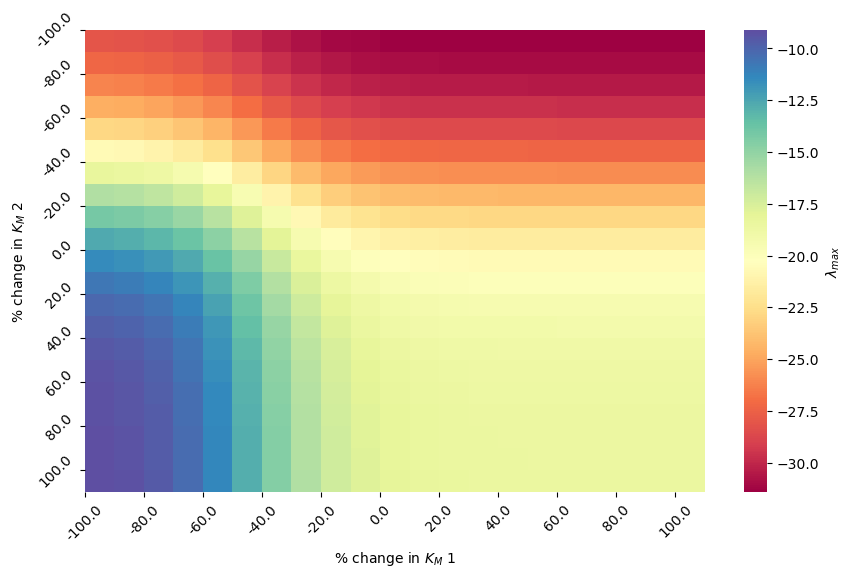

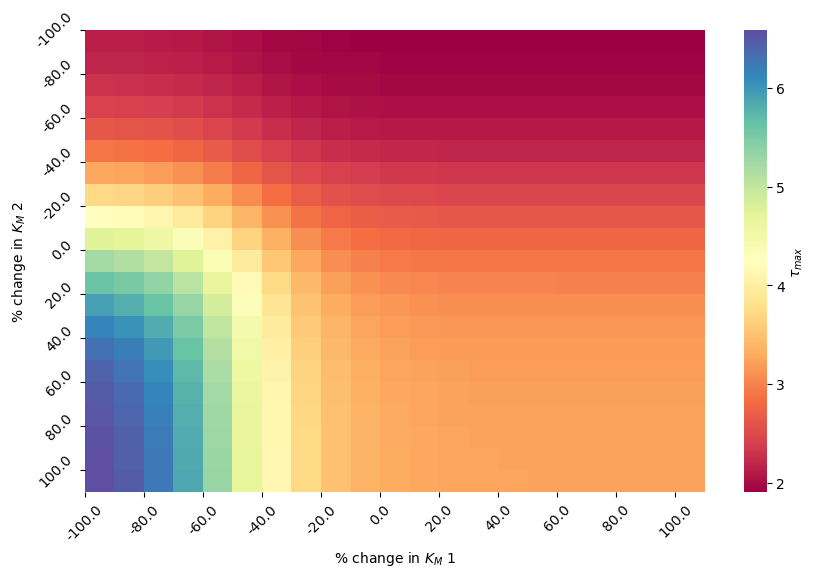

***************


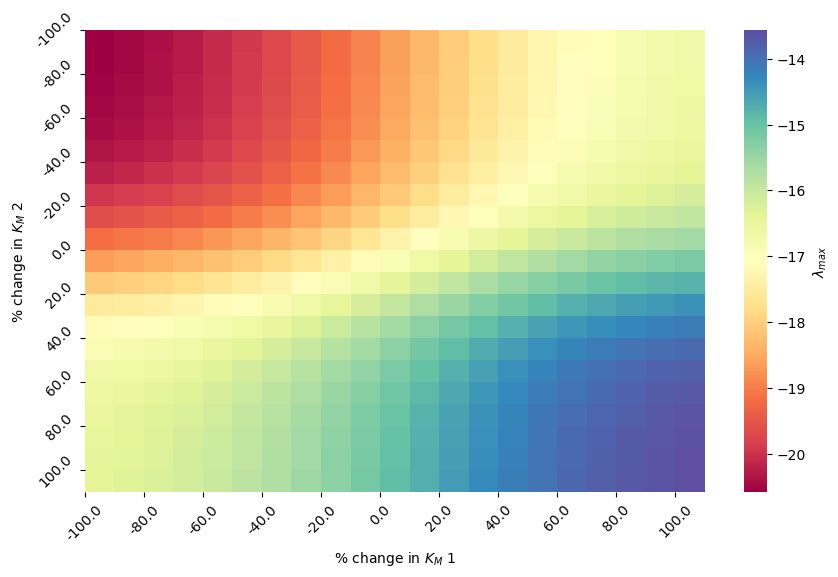

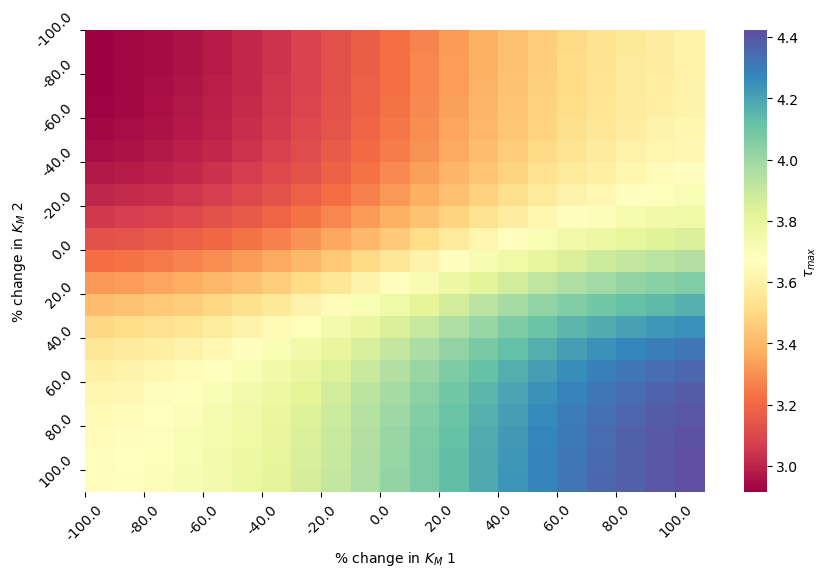

***************


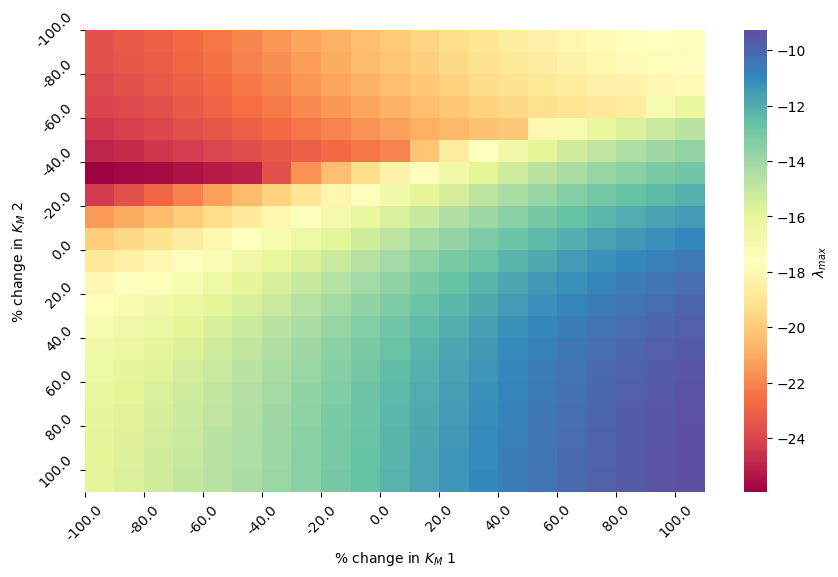

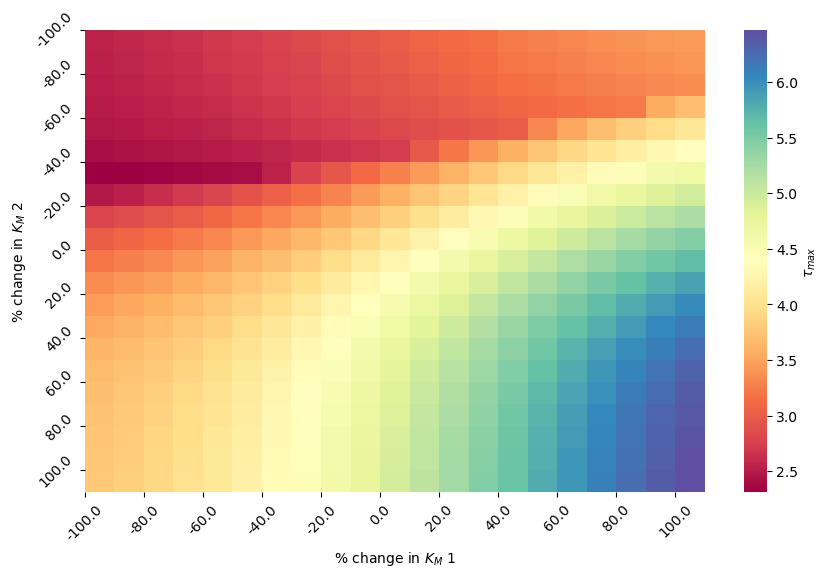

***************


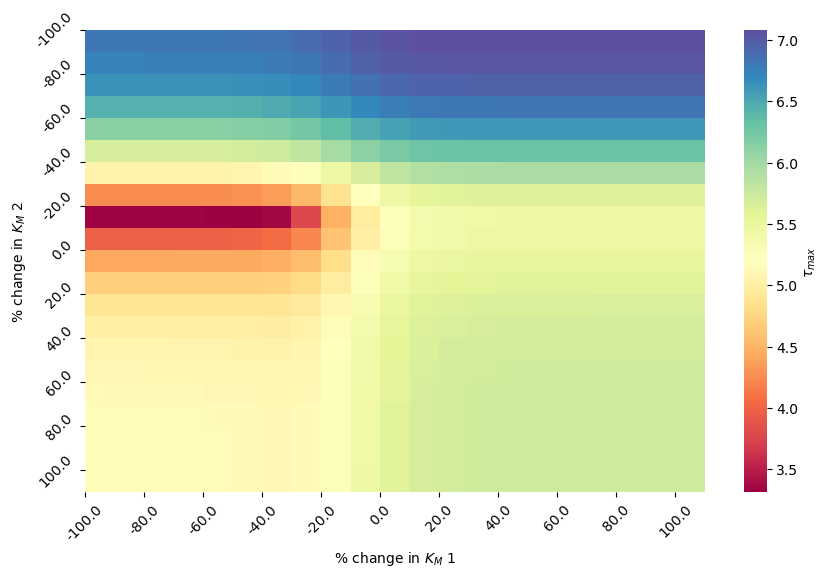

***************


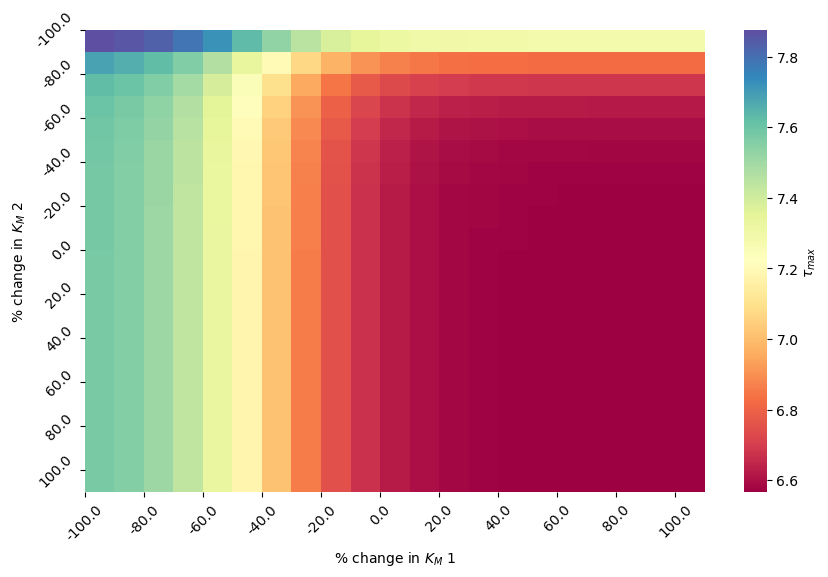

***************


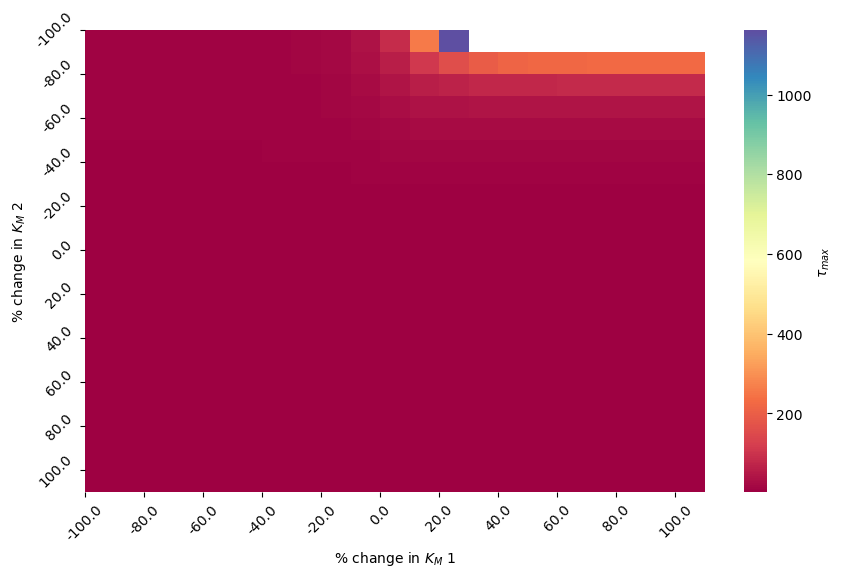

***************


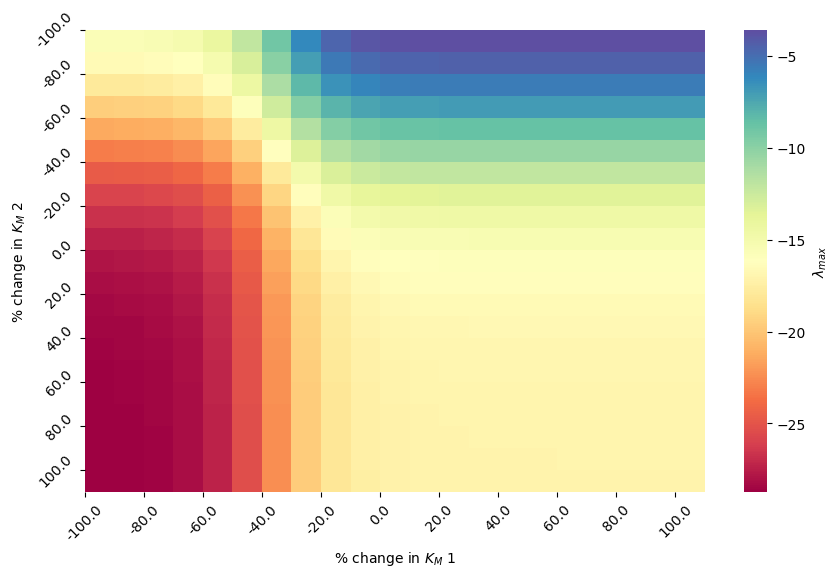

***************


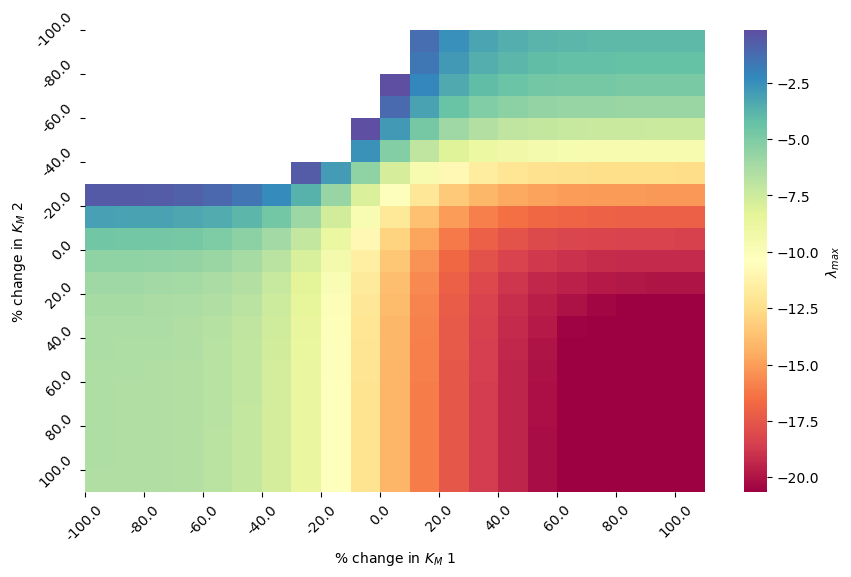

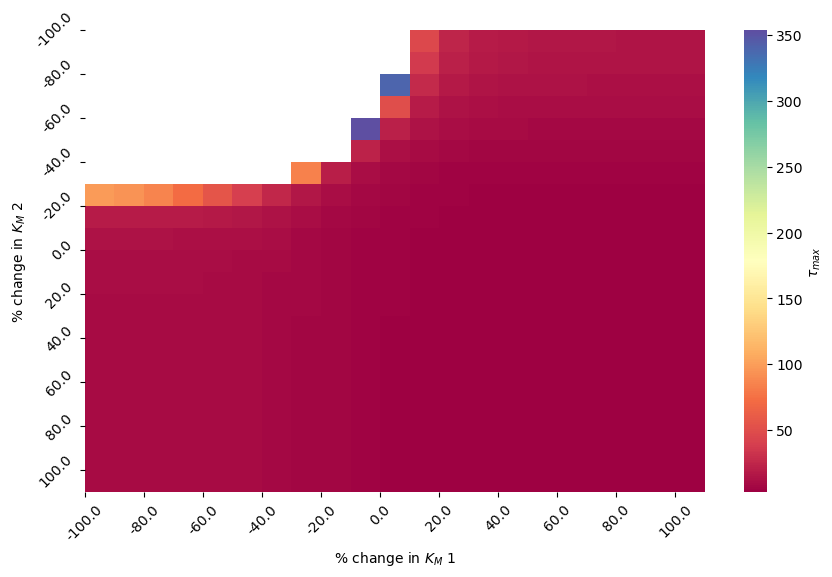

***************


***************


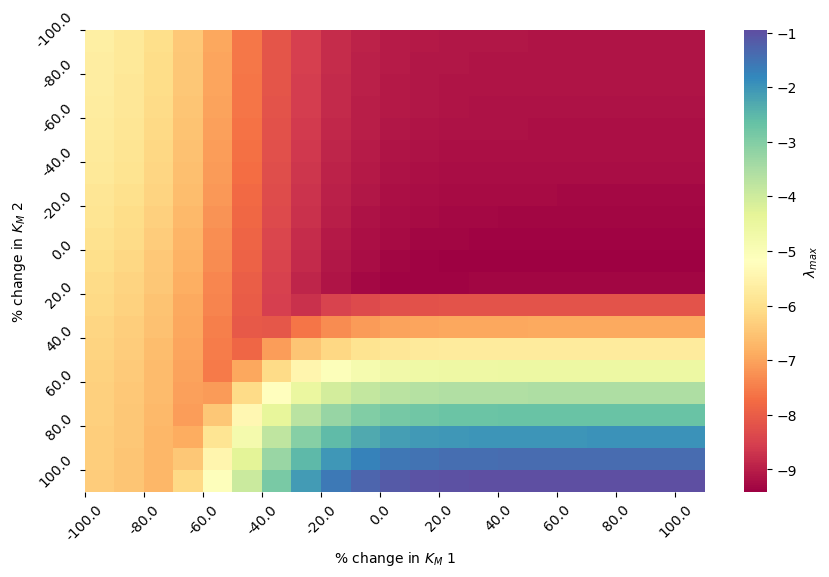

***************


In [360]:
ss = [2, 4, 5]
# Step 1: Determine the global min and max for the colorbar scale
global_min = float('inf')
global_max = float('-inf')
# First pass: Find the min and max values
for ss_idx in ss:
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    for ix in ixs:
        perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/max_eig.csv').iloc[:, 1].values
        latent_mat = np.reshape(perturbed_eigs, (21, 21))
        global_min = min(global_min, latent_mat.min())
        global_max = max(global_max, latent_mat.max())

# Step 2: Generate the heatmaps with consistent colorbar scale
for ss_idx in ss:
    ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:, 1].values
    plot_path = f'analysis/{ss_idx}/figures'
    for ix in ixs:
        perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/max_eig.csv').iloc[:, 1].values
        
        # Plot lambda max landscape
        
        latent_mat = np.reshape(perturbed_eigs, (21, 21))
        # Set values greater than 0 to NaN
        latent_mat[latent_mat > 0] = np.nan

        plt.figure(figsize=(10, 6))
        #plt.title(f'{ss_idx}:{ix}')
        #sns.heatmap(latent_mat, cmap='Spectral', vmin=global_min, vmax=global_max)
        sns.heatmap(latent_mat, cmap='Spectral', cbar_kws={'label': r'$\lambda_{max}$'})
        plt.xticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
        plt.yticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
        plt.xlabel(r'% change in $K_M$ 1')
        plt.ylabel(r'% change in $K_M$ 2')
        plt.savefig(f'{plot_path}/{ix}_km_heatmap_lambda.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_km_heatmap_lambda.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

        # Plot tau max landscape
        
        latent_mat = np.reshape(perturbed_eigs, (21, 21))
        latent_mat = -60/latent_mat
        # Set values less than 0 to NaN
        latent_mat[latent_mat < 0] = np.nan

        plt.figure(figsize=(10, 6))
        #plt.title(f'{ss_idx}:{ix}')
        #sns.heatmap(latent_mat, cmap='Spectral', vmin=global_min, vmax=global_max)
        sns.heatmap(latent_mat, cmap='Spectral', cbar_kws={'label': r'$\tau_{max}$'})
        
        plt.xticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
        plt.yticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
        plt.xlabel(r'% change in $K_M$ 1')
        plt.ylabel(r'% change in $K_M$ 2')
        plt.savefig(f'{plot_path}/{ix}_km_heatmap_tau.svg', dpi=300, transparent=False, bbox_inches='tight')
        plt.savefig(f'{plot_path}/{ix}_km_heatmap_tau.png', dpi=300, transparent=False, bbox_inches='tight')
        plt.show()
        plt.close()

        print('***************')

/tmp/ipykernel_187283/1339259334.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(-60/this_mat[:,0], np.arange(len(this_mat[:,0])), marker = 'o')


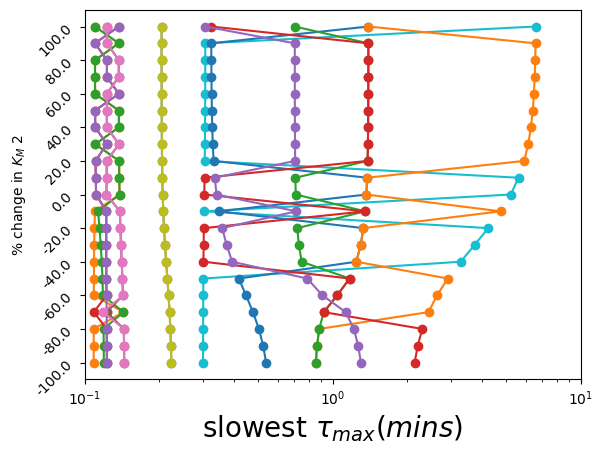

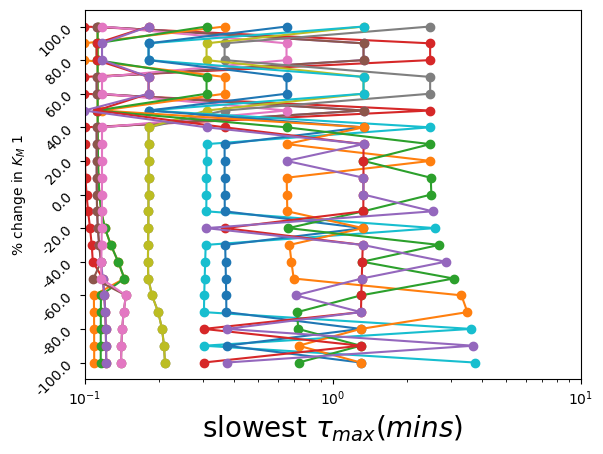

In [365]:
eigs = pd.read_csv(f'analysis/4/km_heatmap/13/all_eigs.csv')
plot_path = 'analysis/4/figures' 
plt.figure()
for j in range(np.shape(eigs)[1]):
    this_mass_action = eigs.iloc[:,j].values
    this_mat = np.reshape(this_mass_action, (21,21))
    plt.plot(-60/this_mat[:,0], np.arange(len(this_mat[:,0])), marker = 'o')
    
plt.xscale('log')
plt.xlabel(r'slowest $\tau_{max} (mins)$', fontsize = 20)
plt.yticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
plt.ylabel(r'% change in $K_M$ 2')
plt.xlim([10**(-1),10])
plt.savefig(f'{plot_path}/km_dancing_taus_1_13.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/km_dancing_taus_1_13.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
for j in range(np.shape(eigs)[1]):
    this_mass_action = eigs.iloc[:,j].values
    this_mat = np.reshape(this_mass_action, (21,21))
    plt.plot(-60/this_mat[7,:], np.arange(len(this_mat[7,:])), marker = 'o')
    
plt.xscale('log')
plt.xlabel(r'slowest $\tau_{max} (mins)$', fontsize = 20)
plt.yticks(np.arange(21)[::2], np.linspace(-100, 100, num=21)[::2], rotation=45)
plt.ylabel(r'% change in $K_M$ 1')
plt.xlim([10**(-1),10])
plt.savefig(f'{plot_path}/km_dancing_taus_1_13.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/km_dancing_taus_1_13.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()